<a href="https://colab.research.google.com/github/yousefhassan1999/Computer-Vision---Asg-2/blob/main/Computer_Vision_Asg_2_Part_1_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

In [ ]:
%%shell
gdown 1B9o6tgqVD4c-BAACG8mY4dpdxQyCMxKG
gdown 1_8CtVwSe0-l409FiD1YwAfOBC9-phZPi
gdown 1bmJGLLdpyE5KHuVtIiJElzhHa9BG8Og_

Downloading...
From: https://drive.google.com/uc?id=1B9o6tgqVD4c-BAACG8mY4dpdxQyCMxKG
To: /content/book.mov
100% 28.5M/28.5M [00:00<00:00, 164MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_8CtVwSe0-l409FiD1YwAfOBC9-phZPi
To: /content/ar_source.mov
100% 6.29M/6.29M [00:00<00:00, 282MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bmJGLLdpyE5KHuVtIiJElzhHa9BG8Og_
To: /content/cv_cover.jpg
100% 117k/117k [00:00<00:00, 103MB/s]


In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames

In [ ]:
# Read videos using cv2
ar_source = loadVid('ar_source.mov')    # 511 frames 360x640
book = loadVid('book.mov')           # 641 frames 480x640

In [ ]:
print(ar_source.shape)
print(book.shape)

(511, 360, 640, 3)
(641, 480, 640, 3)


In [ ]:
cv_cover = cv2.imread('cv_cover.jpg')
print(cv_cover.shape)

(440, 350, 3)


In [ ]:
def cropBlackBar(img):
    # convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # invert gray image
    gray = 255 - gray
    # gaussian blur
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    # threshold
    res = cv2.threshold(blur, 235, 255, cv2.THRESH_BINARY)[1]
    # use morphology to fill holes at the boundaries
    kernel = np.ones((5,5), np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
    # invert back
    res = 255 - res
    # get contours and get bounding rectangle
    contours, _ = cv2.findContours(res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return x, y, w, h

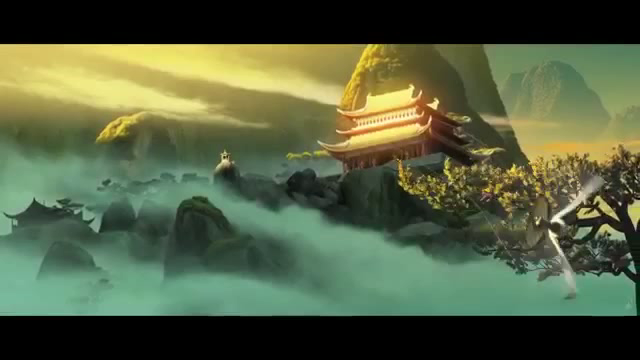

0 43 640 274


In [ ]:
# Crop the top & bottom black bar
frame0 = ar_source[0]
cv2_imshow(frame0)
x, y, w, h = cropBlackBar(frame0)
print(x, y, w, h)

In [ ]:
# # Crop all frames in ar_source
new_source = np.array([f[y:y+h, x:x+w] for f in ar_source])

In [ ]:
def plt_imgs(imgs, labels, figsize=(16, 9), cmap = None):
  assert len(imgs) == len(labels) and len(imgs) > 0
  
  fig, ax = plt.subplots(1, len(imgs), constrained_layout=False, figsize=figsize)
  for i in range(len(imgs)):
    curr_ax = ax[i] if len(imgs) > 1 else ax
    curr_ax.axis('off')
    curr_ax.imshow(imgs[i], cmap)
    curr_ax.set_title(labels[i])
  
  plt.show()

In [ ]:
def find_correspondences(disc1, disc2, k=2, ratio=0.75):
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  knn_result = bf.knnMatch(disc1, disc2, 2)

  final_result = []
  for c1, c2 in knn_result:
    if c1.distance < c2.distance * ratio:
      final_result.append(c1)

  return final_result

In [ ]:
from math import inf, ceil, floor

def weighted_inter(img, x, y):
  h, w, _ = img.shape
  t, d = (floor(y), ceil(y))
  l, r = (floor(x), ceil(x))

  valid_t = t >= 0 and t < h
  valid_d = d >= 0 and d < h
  valid_l = l >= 0 and l < w
  valid_r = r >= 0 and r < w

  I_tl = img[t, l, :] if valid_t and valid_l else 0
  I_tr = img[t, r, :] if valid_t and valid_r else 0
  I_dl = img[d, l, :] if valid_d and valid_l else 0
  I_dr = img[d, r, :] if valid_d and valid_r else 0

  return abs(y - t) * abs(x - l) * I_dr\
        + abs(y - t) * abs(x - r) * I_dl\
        + abs(y - d) * abs(x - l) * I_tr\
        + abs(y - d) * abs(x - r) * I_tl

def nearest_inter(img, x, y):
  h, w, _ = img.shape
  n_x, n_y = round(x), round(y)
  return img[n_y, n_x, :] if n_y >= 0 and n_y < h and n_x >= 0 and n_x < w else 0

def point(x, y):
  return np.array([x,y,1]).reshape((3, 1))

def warpPerspective(img, H, size):
  w, h = size

  if(len(img.shape) == 2): 
    img = img.reshape(img.shape + (-1,))
  warpedImg = np.zeros((h, w, img.shape[2]), dtype=np.ubyte)

  # Forward Warping
  # for y in range(img.shape[0]):
  #   for x in range(img.shape[1]):
  #     P = H @ point(x, y)
  #     P = P / P[2]
  #     warpedImg[int(P[1] - minY), int(P[0] - minX)] = img[y, x]

  # Inverse Warping
  H_inv = np.linalg.inv(H)
  for y in range(warpedImg.shape[0]):
    for x in range(warpedImg.shape[1]):
      P = H_inv @ point(x, y)
      P = (P / P[2]).reshape(-1)
      warpedImg[y, x, :] = nearest_inter(img, P[0], P[1])
  
  if warpedImg.shape[2] == 1:
    warpedImg = warpedImg.reshape(warpedImg.shape[0], -1)

  return warpedImg

In [ ]:
##### Random Sample Consensus (RANSAC) Algorithm:
# 1. Randomly choose s samples. Typically s is the minimum samples to fit a model. For homography: s = 4 points

# 2. Fit the model to the randomly chosen samples.

# 3. Count the number M of data points (inliers) that the model within a measure of error ε.

# 4. Repeat Steps 1-3 N times, until the best model is found with high confidence

# 5. Choose the model that has the largest number of inliers.

def Homography_RANSAC(locs1, locs2,p=0.99,threshold=10):

	# Swap columns in locs because they are in the form of [y, x] returned by matchPics
	locs1 = np.fliplr(locs1)
	locs2 = np.fliplr(locs2)
	
	N = np.inf
	sample_count = 0
	max_num_inliers = 0

	while N > sample_count:#  4. Repeat Steps 1-3 N times, until the best model is found with high confidence

	# 1. Randomly choose s samples. Typically s is the minimum samples to fit a model. For homography: s = 4 points
		r = np.random.choice(len(locs1), 4)
		random_pts_1 =  np.asarray([locs1[i] for i in r], dtype=np.float32)
		random_pts_2 = np.asarray([locs2[i] for i in r], dtype=np.float32)
	
	# 2. Fit the model to the randomly chosen samples.
		H = computeH(random_pts_1, random_pts_2)
	

	# 3. Count the number M of data points (inliers) that the model within a measure of error ε.
		inlier_count = 0
		inliers = []
		for p1, p2 in zip(locs1, locs2):#for every two corresponding points

			# Convert to homogeneous coordinates   p = [x y 1]T
			p_homogeneous = (np.append(p2, 1)).reshape(3, 1) 
			# Multiply by the homography matrix    p' = H.P
			p_dash = H @ p_homogeneous
			# Convert back to heterogeneous coordinates   p' = [x' y' w']T   =>  p'=[x'/w'  y'/w']T
			p_dash = (p_dash/p_dash[2])[:2].reshape(1, 2)
			
			# calculate euclidean distance between the two points (the point the model gave and the actual point) 
			if cv2.norm(p1 - p_dash) <= threshold:
				inlier_count += 1
				inliers.append(1)
			else:
				inliers.append(0)
		
	# 5. Choose the model that has the largest number of inliers.
		if inlier_count > max_num_inliers:  
			max_num_inliers = inlier_count
			bestH = H
			inliers.append(p1)

		inlier_ratio = inlier_count / len(locs2)
		if np.log(1 - (inlier_ratio**8)) == 0:
			continue
		
		N = np.log(1-p) / np.log(1 - (inlier_ratio**8))
		sample_count += 1

	return bestH, inliers

def computeH(x1, x2):
	#Compute the homography between two sets of points
	A = []
	for i in range(len(x1)):
		x2_1, y2_2 = x2[i][0], x2[i][1]
		x1_1, y1_2 = x1[i][0], x1[i][1]
		A.append([x2_1, y2_2, 1, 0, 0, 0, -x1_1 * x2_1, -x1_1 * y2_2, -x1_1])
		A.append([0, 0 , 0, x2_1, y2_2, 1, -y1_2 * x2_1, -y1_2 * y2_2, -y1_2])
    
	A = np.array(A)
	U, D, V_t = np.linalg.svd(A)
    # the solution will be the last column (the eigenvector corresponding to the smallest eigenvalue) of the orthonormal matrix 
		# normalize by dividing by the element at (3,3) W 
	H = np.reshape(V_t[-1, :], (3, 3))
	return H


def compositeH(H2to1, template, img):
	#Create a composite image after warping the template image on top of the image using the homography

	#For warping the template to the image, we need to invert it.
	H_inv = np.linalg.pinv(H2to1)

	#Create mask of same size as template
	mask = np.ones(template.shape)
 
	#Warp mask by appropriate homography
	mask_warp = warpPerspective(mask, H_inv, (img.shape[1], img.shape[0]))
 
	#Warp template by appropriate homography
	template_warp = warpPerspective(template, H_inv, (img.shape[1], img.shape[0]))
 
	#Use mask to combine the warped template and the image
	composite_img = template_warp + img * np.logical_not(mask_warp)
 
	return composite_img


In [ ]:
def homography_warp(args):
    ar_source_crop, cv_cover, book= args
    final = book.copy()
    # adjusting ar_source frame
  
    #Convert Images to GrayScale
    I1_gray = cv2.cvtColor(cv_cover, cv2.COLOR_BGR2GRAY)
    I2_gray = cv2.cvtColor(book, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    (pts1, disc1) = sift.detectAndCompute(I1_gray, None)
    (pts2, disc2) = sift.detectAndCompute(I2_gray, None)

    locs1=[]
    for x in pts1:
      locs1.append([x.pt[1] , x.pt[0]])
    locs1 = np.asarray(locs1)

    locs2=[]
    for x in pts2:
      locs2.append([x.pt[1] , x.pt[0]])
    locs2 = np.asarray(locs2)

    matches = find_correspondences(disc1, disc2)

    matchesPos=[]
    for x in matches:
      matchesPos.append([x.queryIdx , x.trainIdx])
    matchesPos = np.asarray(matchesPos)
    corr_img = cv2.drawMatches(cv_cover, pts1, book, pts2, 
                           np.random.choice(matches, 50), None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # plt_imgs([corr_img], ["Correspondences"], (20, 10))
    
    bestH, _ = Homography_RANSAC(locs1[matchesPos[:, 0]], locs2[matchesPos[:, 1]])


    h, w = cv_cover.shape[:2]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    H_inv = np.linalg.pinv(bestH)

    transformedCorners = cv2.perspectiveTransform(corners, H_inv)

    centerOfAugmanted = tuple(ti/2 for ti in ar_source_crop.shape )
    w_augmanted = abs(int(transformedCorners[0][0][0]-transformedCorners[3][0][0]))  #y
    h_augmanted = abs(int(transformedCorners[0][0][1]-transformedCorners[2][0][1]))  #x
    x_augmanted = abs(int(centerOfAugmanted[1] - w_augmanted/2))
    y_augmanted = abs(int(centerOfAugmanted[0] - h_augmanted/2))

    
    ar_source_crop = ar_source_crop[y_augmanted:y_augmanted+h_augmanted,x_augmanted:x_augmanted+w_augmanted]

    ar_source_crop = cv2.resize(ar_source_crop, dsize=(cv_cover.shape[1],cv_cover.shape[0]))

    composite_img = compositeH(bestH, ar_source_crop, final)

    return composite_img

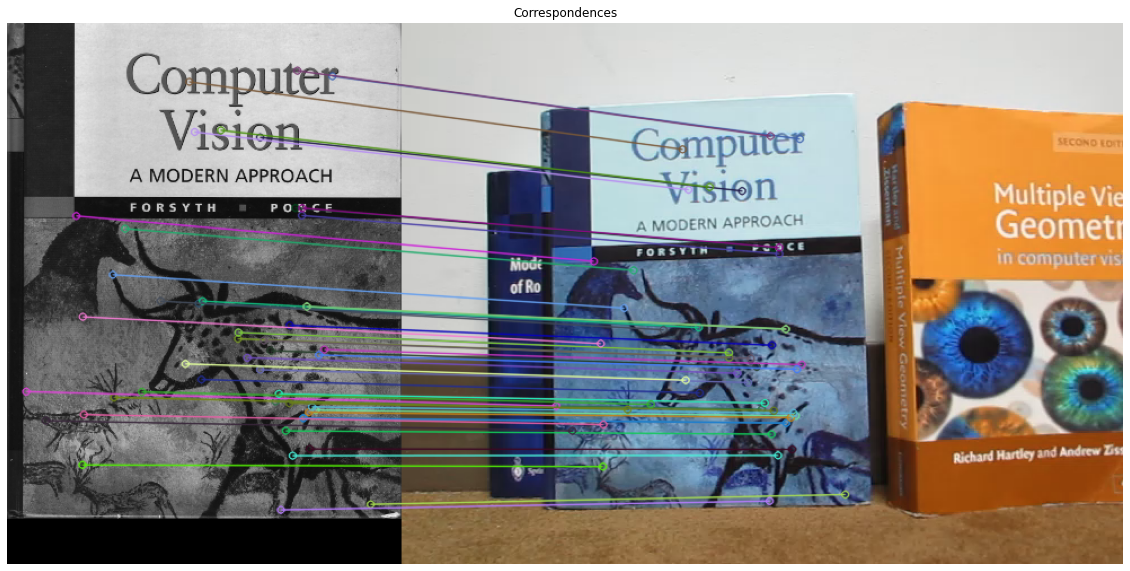

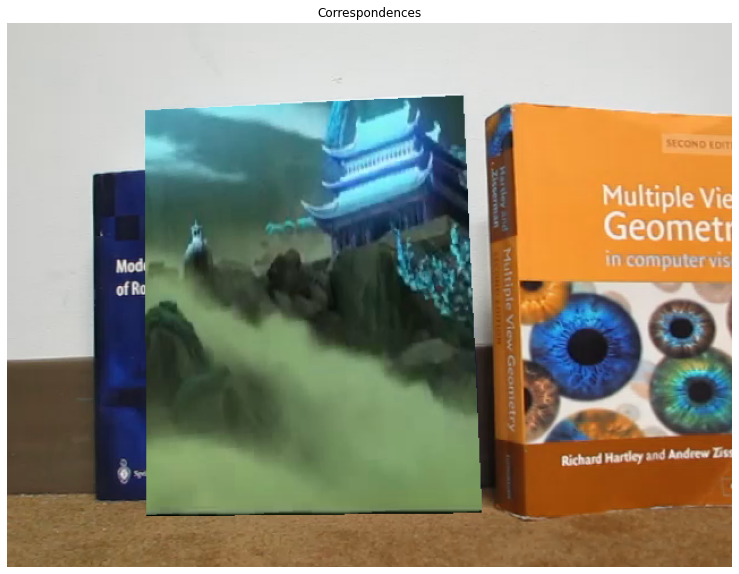

In [ ]:
plt_imgs([homography_warp([new_source[0], cv_cover, book[0]])], ["Correspondences"], (20, 10)) 

In [ ]:
args=[]
for i in range(len(new_source)):
    args.append([new_source[i], cv_cover, book[i]])
arr = map(homography_warp, args)
ar = list(arr)

In [ ]:
ar = np.array(ar)
writer = cv2.VideoWriter('ar.avi', cv2.VideoWriter_fourcc(*'MJPG'), 25, (ar.shape[2], ar.shape[1]))
for i, f in enumerate(ar):
    writer.write(f)

writer.release() 